# Practical for CS in Spectroscopy

# 1. the $\ell_1$ norm vs the $\ell_2$ norm

$\ell_1$ is defined as :

$$
\ell_1(x) = \sum_i{|x_i|}
$$

to be compared with the classical *cartesian* $\ell_2$ norm :

$$
\ell_2(x) = \sqrt{\sum_i{x_i^2}}
$$

Minimizing the a target function over set of experimental points by minimizing the $\ell_2$ norm of the difference between the experimental points and the computed points, is called the Maximum Likelyhood approach. It is equivalent to searching the most probable data-set given the parameters and a model.

It is the classical way of *fitting* parameters.

Let's take an example

define the Exponential shape:
$$
E(x, A,\sigma) = A e^{-\sigma x}
$$
where
- $x$ is the running coordinate
- $A$ is the amplitude
- $\sigma$ is the inverse of the caracteristic decay



In [1]:
import numpy as np
def Exponen(x, A, sigma):
    "function for Exponential decay "
    return A*np.exp(-sigma*x)

We can use it

In [2]:
print (Exponen(5, A=100, sigma=0.3))

22.3130160148


and plot it

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

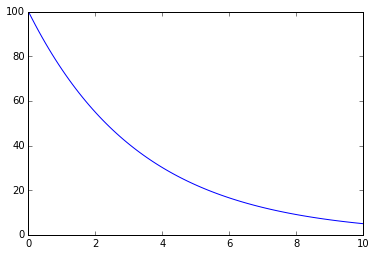

In [3]:
x = np.linspace(0,10,100)
y = Exponen(x, A=100, sigma=0.3)
plt.plot(x, y)

to simulate fitting, we first generate a noisy version of this curve:

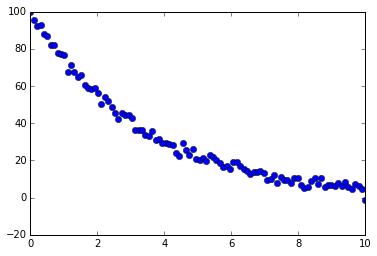

In [4]:
noise = 2.0
y_meas = Exponen(x, A=100, sigma=0.3) + noise*np.random.randn(len(y))
# np.random.randn returns a random series with a normal distribution.
plt.plot(x, y_meas,'o')

# Fitting the data

in this purpose, we compute the difference between the experimental data, and the analytical model we use (Here Exponential).

In the "fitting" context, we need to have $func()$ return the difference between the constructed values and measured ones, it is generally called the *residual*

so we need to compute
$$
E_{res}(x, y_{meas},  A,\sigma) = y_{meas} - E(x,  A,\sigma)
$$


In [7]:
def Eres(param, x, y_meas):
    "compute the residual"
    (A, sigma) = param
    res = y_meas - Exponen(x, A, sigma) 
    return res

square root of sum of squares: 95.693678
sum of absolute values: 698.635678


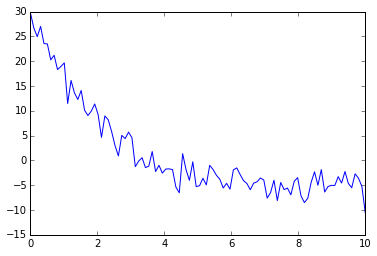

In [8]:
# ploting with a slight missmatch :
plt.plot(x, Eres((70, 0.2), x, y_meas) )
print ("square root of sum of squares: %f"%np.sqrt( sum( Eres((70, 0.2), x, y_meas)**2 )) )
print ("sum of absolute values: %f"%sum( abs(Eres((70, 0.2), x, y_meas) )))

### Minimizing the norm of the residual

To *fit* means that we want to find the parameters of the model that minimize the *intensity* of the residual.

The maximum Likelyhood solution consists in minimizing the sum of the square of the residual.

There is a large range of utilities in `scipy` to do this, in particular check the `scipy.optimize` package 

Now we are going to use `leastsq()` ( `curve_fit()` *would be simpler, but less didactic* )

given `leastsq(f, p0, (x,y) )` the function `leastsq()` minimizes the following value :
$$
    arg min_{p_j}(Q(p_j) = \sum_i(f(p_j, x_i, y_i)^2))
$$

whe $p_j$ are the parameters to find.

It does it very efficiently because it can estimate the derivatives $\frac {\partial Q}{\partial p_j}$ of $Q$
$$
\frac {\partial Q}{\partial p_j} = 2 f \frac {\partial f}{\partial p_j}
$$
and $\frac {\partial f}{\partial p_j}$ by small displacement analysis, using an algorithm called *Levenberg-Marquardt"



In [11]:
from scipy.optimize import leastsq
#leastsq?

# we need an initial *guessed* value
Po = (70, 0.2)
# then call it :
res_l2 = leastsq(Eres, Po, (x,y_meas))
P_fit = res_l2[0]  # res is an array, res[0] contains the fitted values
print(P_fit)

[ 99.9790423    0.29946053]


not too bad for a target of `[100.0  0.3]`
and we compute the relative precision, and plot the result :

[ 99.9790423    0.29946053]
relative error: 0.1 %


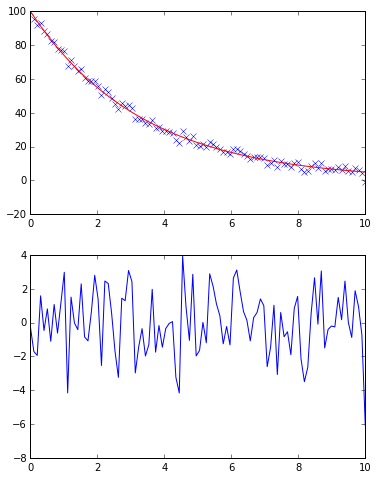

In [14]:
def show_Eres(P, x, y):
    print(P)
    P_o = np.array([100,0.3])
    print("relative error: %.1f %%"%(100*sum(abs(P-P_o)/P_o)/len(P_o)))
    plt.figure(figsize=(6,8))
    plt.subplot(211)
    plt.plot(x, y,'x')
    plt.plot(x, Exponen(x, *P), 'r' )

    plt.subplot(212)
    plt.plot(x, Eres(P, x, y) )
show_Eres(P_fit, x, y_meas)

To do the same in $\ell_1$ we have to ressort to another (slower) minimizer. I'll choose `powell`.

**non derivable**

In [16]:
from scipy.optimize import minimize


[ 99.69262738   0.29887974]
relative error: 0.3 %


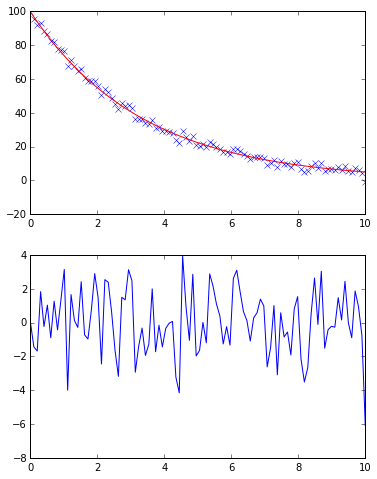

In [17]:
def Eres_Sum_L1(param, x, y_meas):
    return sum( abs( Eres(param, x, y_meas)))

res_l1 = minimize(Eres_Sum_L1, Po, args=(x,y_meas), method="Powell")
P_fit = res_l1.x

show_Eres(P_fit, x, y_meas)

it seems to work just as well !

we can make it into one single function similar to `leastsq()` for more convenience.

In [19]:
def leastL1(func, x0, args):
    "same as leastsq, but minimizes sum(abs(func(x)-y))"
    Sum_L1 = lambda  p, x, y: sum( abs( func(p, x, y) ) )
    res_l1 = minimize(Sum_L1, x0, args=args, method="Powell")
    return (res_l1.x, 1) # second argument is used to mimic leastsq

[ 99.69262738   0.29887974]
relative error: 0.3 %


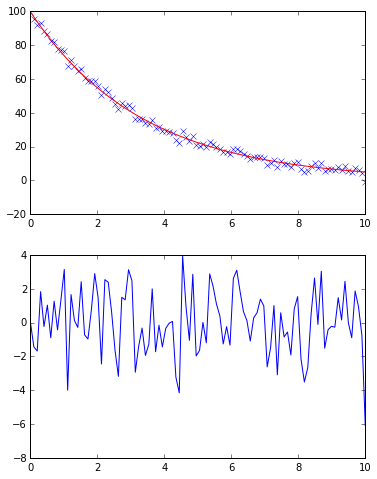

In [20]:
res_l1 = leastL1(Eres, Po, (x,y_meas))
P_fit = res_l1[0]     # res is an array, res[0] contains the fitted values
show_Eres(P_fit, x, y_meas)

### comparison $\ell_1$ vs $\ell_2$ for function fit
We've seen that superficially, minimizing $\ell_1$ or $\ell_2$ seems very similar.

Let's put some outliers to the experimental measure, and see how it behaves.


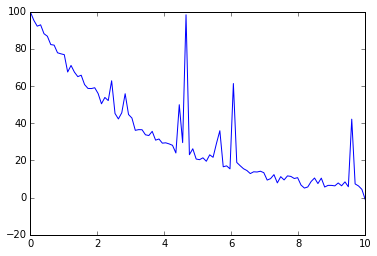

In [24]:
import random
y_meas2 = y_meas.copy()
for i in range(10):
    index = int(len(x)*random.random())   # choose a position
    y_meas2[index] += 80*random.random()  # add a positive random value
plt.plot(x, y_meas2)

[ 97.4212522    0.26544206]
relative error: 7.0 %
[ 99.69262738   0.29800276]
relative error: 0.5 %


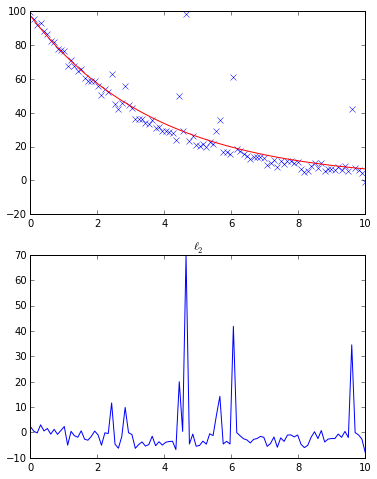

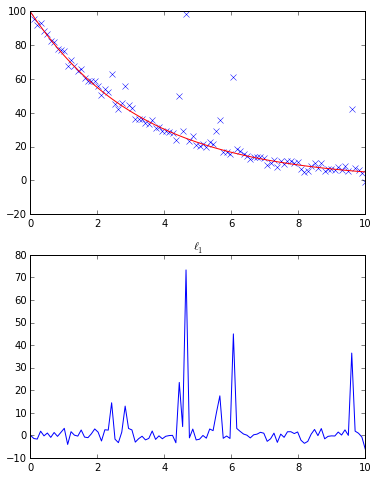

In [25]:
res_l2 = leastsq(Eres, Po, (x,y_meas2))
P_fit = res_l2[0]     # res is an array, res[0] contains the fitted values
show_Eres(P_fit, x, y_meas2)
plt.title("$\ell_2$")
plt.figure()

res_l1 = leastL1(Eres, Po, (x,y_meas2))
P_fit = res_l1[0]     # res is an array, res[0] contains the fitted values
show_Eres(-)
plt.title("$\ell_1$")

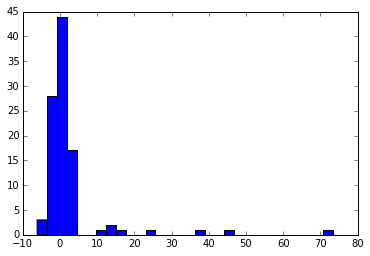

In [29]:
h=plt.hist(Eres(P_fit, x, y_meas2) , bins=30)

##### It seems that $\ell_1$ is more robust against outliers.

It comes from the fact that minimizing the $\ell_1$ norm of the residual is equivalent to maximizing its sparcity. 

In any case, the assumption for Maximum Likelyhood approach ($\ell_2$ minimization) do not hold here as the noise is certainly not normal.

### Use the same tools in other contexts

- linear fit

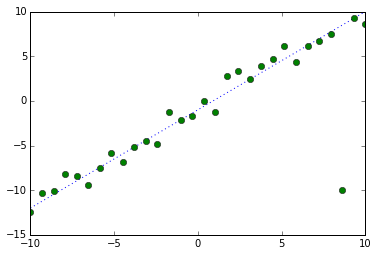

In [30]:
def Linear(x, A, B):
    "Linear function"
    return A*x + B
def Lres(param, x, y_meas):
    "compute the residual"
    return y_meas - Linear(x, *param)
x = np.linspace(-10,10,30)
y = Linear(x, 1.1,-1)
y_meas = y + np.random.randn(len(x))
y_meas[27] = -10
plt.plot(x,y, ':')
plt.plot(x,y_meas, 'o')

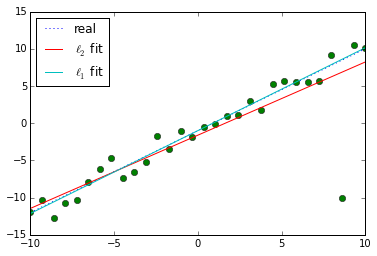

In [17]:
Po = [0,0]

res_l2 = leastsq(Lres, Po, (x,y_meas))
P_fit = res_l2[0]     # res is an array, res[0] contains the fitted values
plt.plot(x ,y, ':', label='real')
plt.plot(x, y_meas, 'o')
plt.plot(x, Linear(x, *P_fit), label='$\ell_2$ fit')

res_l1 = leastL1(Lres, Po, (x,y_meas))
P_fit = res_l1[0]     # res is an array, res[0] contains the fitted values
plt.plot(x, Linear(x, *P_fit),  label='$\ell_1$ fit')
plt.legend(loc=0)

You can try something else
 - Gaussian fit
 - Bessel functions
 - ... anything ...

# random matrix

Random matrices are easy to build in numpy.

They have very peculiar properties.

In [31]:
r = np.random.randn(3,3)  # 3x3 random matric filled with normal law
print(r)

[[-1.53550497  0.32130525  0.27778434]
 [ 0.49935992  1.68817866  2.02240488]
 [-0.26482951 -0.19726991 -0.11881889]]


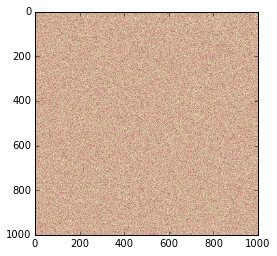

In [32]:
r = np.random.randn(1000,1000)
plt.imshow(r, cmap="pink")

### square of a random matrix


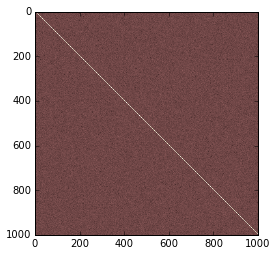

In [33]:
r2 = np.dot(r, r.T)  # r2 is the square of r
plt.imshow(r2, cmap="pink")

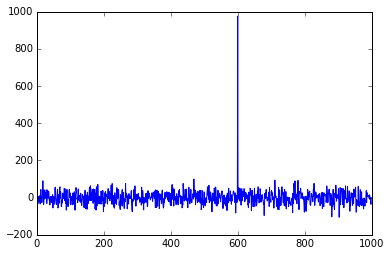

In [34]:
plt.plot(r2[600,:])

it seems that is shows some diagonal

It comes from the fact that, if $X$ and $Y$ two random series, independence means that the Expected for their cross-correlation is zero.
$$
cor(X,Y) = \sum_i^N(X_i Y_i) \\
E( cor(X,Y) ) = 0
$$
while of-course,
$$
cor(X,X) = \sum_i^N(X_i X_i) \\
E( cor(X,X) ) = N
$$

more over, the standard deviation $\sigma$ of $cor(X,Y)$ is :
$$
\sigma(cor(X,Y)) = \sqrt{2N}
$$

So looking to one of the line of the matrix `r2`

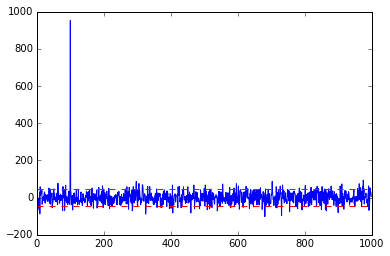

In [19]:
plt.plot(r2[100])
sigma = r2[100,100:].std()
plt.plot([0,r2.shape[1]],[sigma,sigma],'r--')
plt.plot([0,r2.shape[1]],[-sigma,-sigma],'r--')

how does it changes with $N$ ?

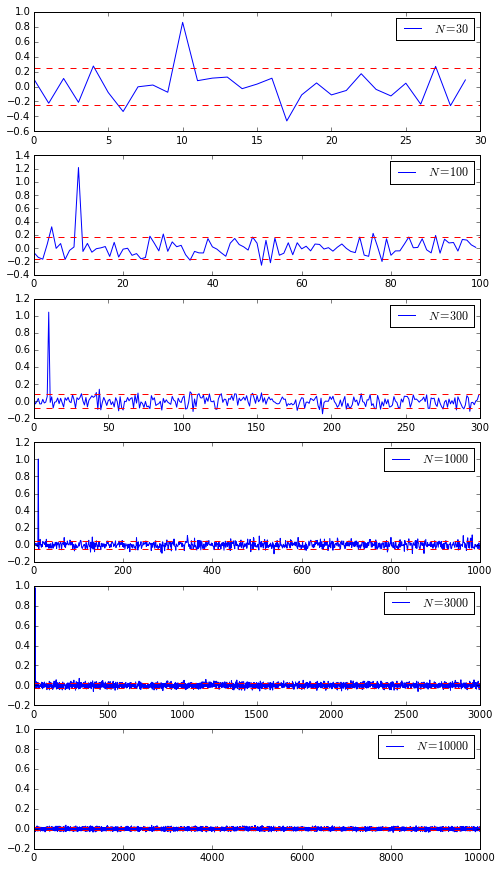

In [35]:
# we create empty lists to store values using list.append()
Es = []              # to store expected values
sigmas = []          # to store standard div

# listN is the sizes for matrices.
# be careful the value 10000 requires about 1.6 Gb of central memory
listN = np.array([30,100,300,1000,3000,10000]) 

plt.figure(figsize=(8,15))
for i,N in enumerate(listN):
    r = np.random.randn(N,N)
    r2 = np.dot(r, r.T)/N
    sigma = r2[10,10:].std()
    Es.append(r2[10,10])
    sigmas.append(sigma)
    
    plt.subplot(len(listN), 1, i+1)
    plt.plot(r2[10], label="$N=%d$"%N)
    plt.plot([0,N],[sigma,sigma],'r--')
    plt.plot([0,N],[-sigma,-sigma],'r--')
    plt.legend()

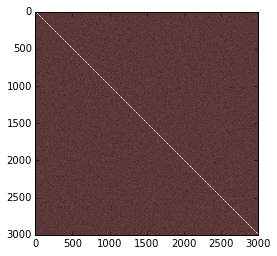

In [9]:
plt.imshow(r2, cmap="pink")

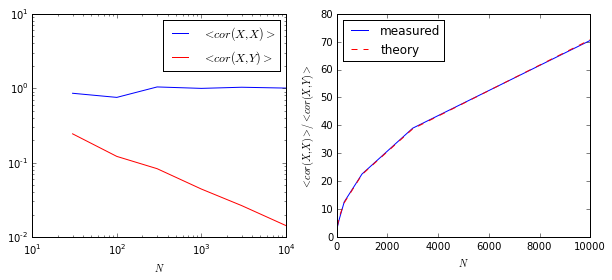

In [215]:
Es = np.array(Es)          # this transforms a plain python list into a nparray
sigmas = np.array(sigmas)  # so one can make computation

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.loglog(listN, Es, label="$<cor(X,X)>$")
plt.loglog(listN, sigmas, 'r', label="$<cor(X,Y)>$")
plt.xlabel("$N$")
plt.legend(loc=0)

plt.subplot(122)
plt.plot(listN, Es/sigmas, label="measured")
plt.plot(listN, np.sqrt(listN/2), 'r--', label="theory" )
plt.xlabel("$N$")
plt.ylabel("$<cor(X,X)>/<cor(X,Y)>$")
plt.legend(loc=0)

Large random matrices behave nearly like orthogonal matrices !

It works also with other random (centered) distributions

In [209]:
#r = 2*np.random.rand(1000,1000)-1                         # equiprobable law  -1.0 1.0
#r = np.sign(np.random.randn(1000,1000))                   # random series of -1 / +1
#r = np.sign(np.random.randn(1000,1000)); r[r<0] = 0.0     # Bernouilli : random 0 and 1

Random matrices can also be rectangular.
For a $N \times P$ matrix, with $N<P$, the direct product produces a
$N \times N$ matrix, close to indentity by $1 \over \sqrt{2P}$

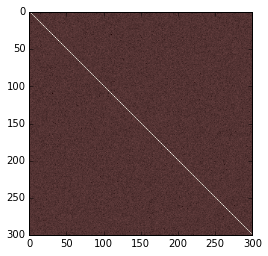

In [12]:
r = np.random.randn(300, 3000)
r2 = np.dot(r, r.T)
plt.imshow(r2, cmap="pink")

This is not so surprizing

What is more surprizing is that the reverse product produces a
$P \times P$ matrix, close to indentity by $1 \over \sqrt{N}$.

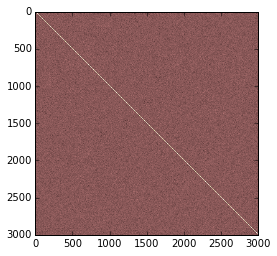

In [13]:
r2 = np.dot(r.T, r)
plt.imshow(r2, cmap="pink")

However we know that the matrix `r2` is non-invertible, as its rank in $N$ and its size in $P \times P$ (remember $P>N$).

# compression

$R Im$

(475, 599, 3)


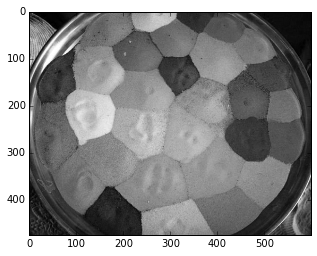

In [29]:
s = plt.imread("/Users/mad/Dropbox/gags/sahara.png")
print(s.shape)
sg = s[:,:,1]
plt.imshow(sg, cmap='gray')

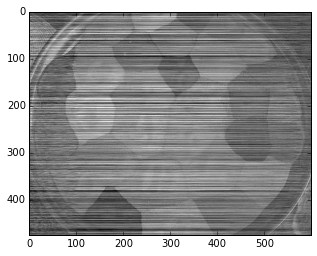

In [64]:
N = 1000
r = np.random.randn(475,N)
sgg = np.dot(r, np.dot(r.T, sg))
plt.imshow(sgg, cmap='gray')


try to play with $N$
